In [206]:
import pandas as pd
import numpy as np
from pyproj import Proj, transform
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib 
import folium
from matplotlib import font_manager, rc
import plotly.express as px
import platform
import json

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~')
    
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)

### 성산읍, 남원읍, 애월읍, 연동, 한림읍, 안덕면, 이도이동, 조천읍의 업종 비교
- 제주시, 서귀포시 오전 10시 ~ 오후 10시 사이 '영세' 음식점업, 소매업 중 총 소비금액 기준 상위 업종

In [182]:
data_url = '../datas/detailed_consume_type_data.csv'
consume_data = pd.read_csv(data_url, sep=',')
jejusi_consume = consume_data[consume_data['Sigungu'] == '제주시']
jejusi_consume.reset_index(drop=True, inplace=True)

# x시 제거
drop_target = jejusi_consume[jejusi_consume['Time']=='x시'].index.tolist()
jejusi_consume = jejusi_consume.drop(index=drop_target)
jejusi_consume.tail(3)

YM     Sido Sigungu FranClass  Type Time  TotalSpent  DisSpent  \
191449  202005  제주특별자치도     제주시        중소   편의점  23시      106200         0   
191450  202005  제주특별자치도     제주시        영세    스넥  23시      200800         0   
191451  202005  제주특별자치도     제주시        영세  일반한식  23시      120000         0   

        NumofSpent  NumofDisSpent      POINT_X      POINT_Y LargeCategory  \
191449          10              0  949566.1569  1502604.267           소매업   
191450           7              0  949616.8571  1502454.567          음식점업   
191451           2              0  950674.5989  1500760.286          음식점업   

                 MediumCategory  
191449                  체인화 편의점  
191450  피자, 햄버거, 샌드위치 및 유사 음식점업  
191451                  한식 음식점업

In [183]:
# 제주시 내 10시 ~ 22시 사이 결제 + 영세 + '소매업', '음식점업' TotalSpent 기준 상위 업종 13개 기준
jejusi_url = '../datas/detailed_consume_type_jejusi.csv'
jejusi_data = pd.read_csv(jejusi_url, sep=',')

# 서귀포시 내 10시 ~ 22시 사이 결제 + 영세 + '소매업', '음식점업' TotalSpent 기준 상위 업종 13개 기준
seogwiposi_url = '../datas/detailed_consume_type_seogwipo.csv'
seogwiposi_data = pd.read_csv(seogwiposi_url, sep=',')

In [184]:
# 제주시 + 서귀포시 데이터
jeju_data = pd.concat([jejusi_data, seogwiposi_data], axis=0)
jeju_data = jeju_data.iloc[:, 4:]
jeju_data.reset_index(drop=True, inplace=True)
len(jeju_data)

86582

In [185]:
# 소비력있는 제주도민이 주로 거주하는 동네 + 관광객이 주로 묵는 호텔이 위치한 읍,면,동 top 8
top_dong = ['성산읍', '남원읍', '애월읍', '연동', '한림읍', '안덕면', '이도이동', '조천읍']
top_dong_df = jeju_data[jeju_data['Dong'].isin(top_dong)]
top_dong_df.reset_index(drop=True, inplace=True)
top_dong_df.tail(2)

Sigungu FranClass  Type Time  TotalSpent  DisSpent  NumofSpent  \
28706    서귀포시        영세  일반한식  13시       50000     30000           2   
28707    서귀포시        영세  일반한식  13시      427000         0          10   

       NumofDisSpent      POINT_X      POINT_Y LargeCategory MediumCategory  \
28706              1  894968.4998  1475453.828          음식점업        한식 음식점업   
28707              0  895946.0817  1480056.477          음식점업        한식 음식점업   

           Proj_X     Proj_Y Dong  
28706  126.370156  33.268103  안덕면  
28707  126.380121  33.309706  안덕면

#### 소비력이 있는 관광객 숙박지역 + 제주도민 거주 지역별 총 소비횟수, 총 소비금액 비교

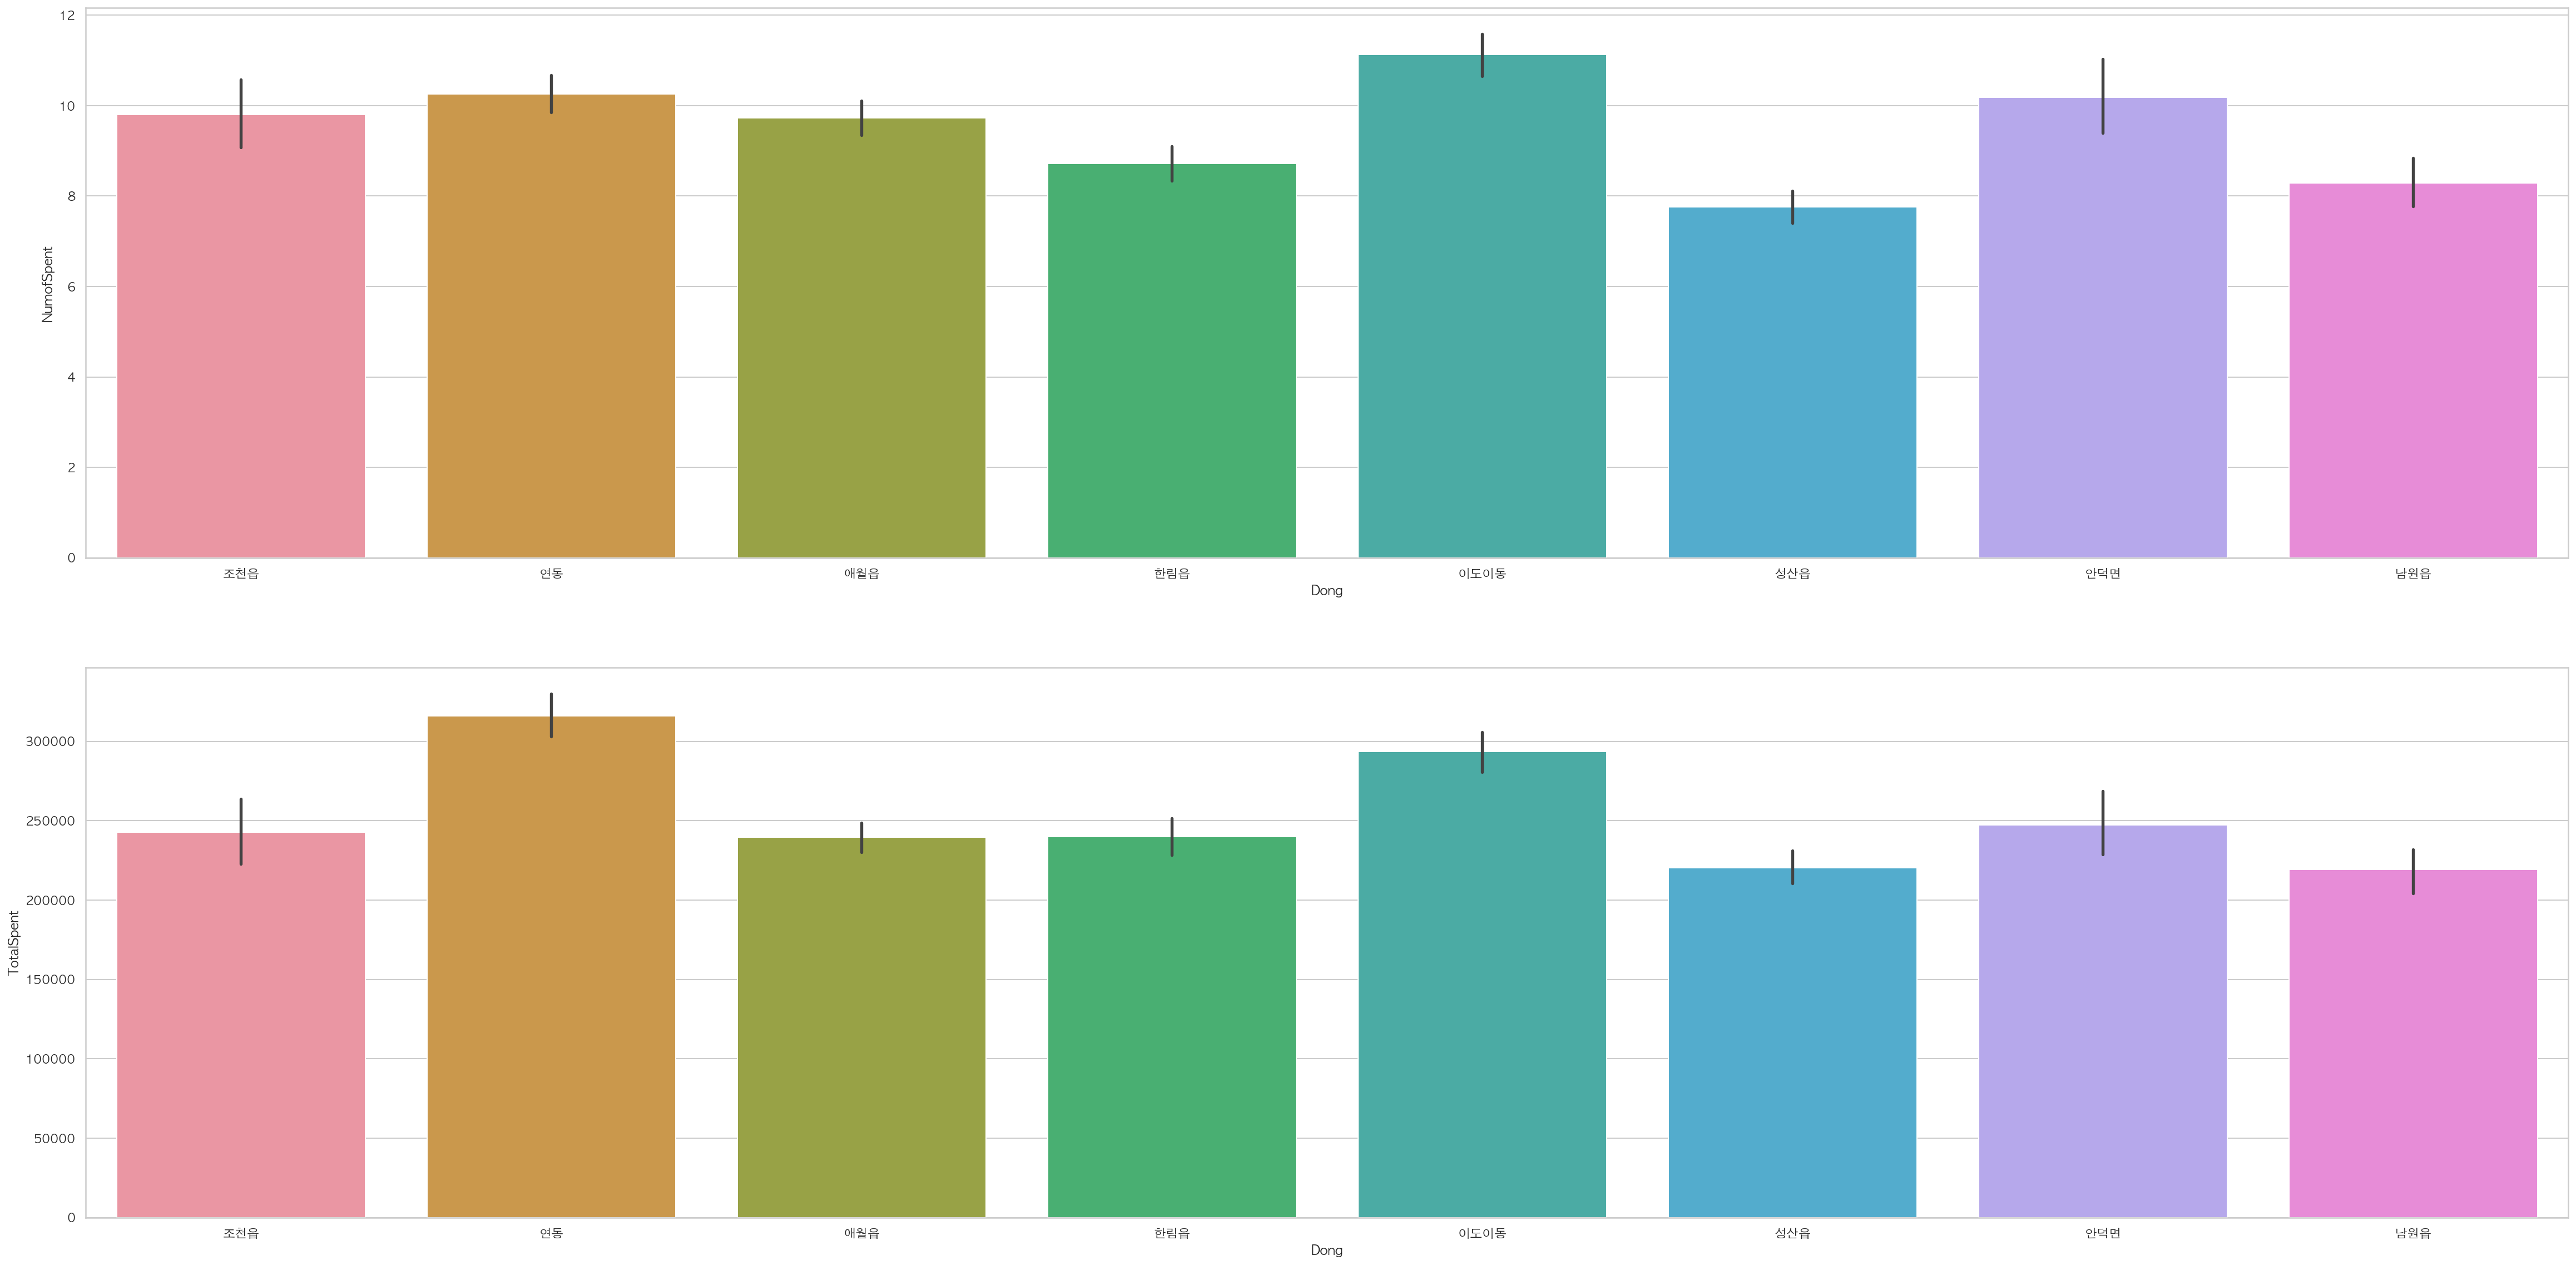

In [186]:
# top 8 읍,면,동 NumofSpent, TotalSpent
sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
fig, axes = plt.subplots(2,1, figsize=(40,20))
sns.set_palette('Greens', 3)

sns.barplot(ax=axes[0], x='Dong', y='NumofSpent', data=top_dong_df)
sns.barplot(ax=axes[1], x='Dong', y='TotalSpent', data=top_dong_df)
plt.show()

#### 매출 Top 10 업종
- 일반한식, 서양음식, 스넥, 편의점, 농축수산품, 슈퍼마켓, 중국음식, 정장, 기타음료식품, 주점	

In [187]:
# 매출 Top 10 업종
type_count = top_dong_df.groupby(['Type']).count()
type_count = type_count[['TotalSpent', 'NumofSpent', 'Dong']].sort_values(by='NumofSpent', ascending=False)[:10]
type_count

TotalSpent  NumofSpent   Dong
Type                                 
일반한식         12655       12655  12655
서양음식          4995        4995   4995
스넥            1563        1563   1563
편의점           1251        1251   1251
농축수산품         1152        1152   1152
슈퍼마켓           853         853    853
중국음식           756         756    756
정장             730         730    730
기타음료식품         722         722    722
주점             586         586    586

In [189]:
# top 8 읍,면,동 지역의 매출 top 10 업종
type_10 = type_count.sort_values(by='NumofSpent', ascending=False)[:10].index.tolist()

top_type_df = top_dong_df[top_dong_df['Type'].isin(type_10)]
top_type_df.reset_index(drop=True, inplace=True)
top_type_df.tail(2)

Sigungu FranClass  Type Time  TotalSpent  DisSpent  NumofSpent  \
25261    서귀포시        영세  일반한식  13시       50000     30000           2   
25262    서귀포시        영세  일반한식  13시      427000         0          10   

       NumofDisSpent      POINT_X      POINT_Y LargeCategory MediumCategory  \
25261              1  894968.4998  1475453.828          음식점업        한식 음식점업   
25262              0  895946.0817  1480056.477          음식점업        한식 음식점업   

           Proj_X     Proj_Y Dong  
25261  126.370156  33.268103  안덕면  
25262  126.380121  33.309706  안덕면

#### Top 10 업종의 총 소비횟수, 총 소비금액 비교

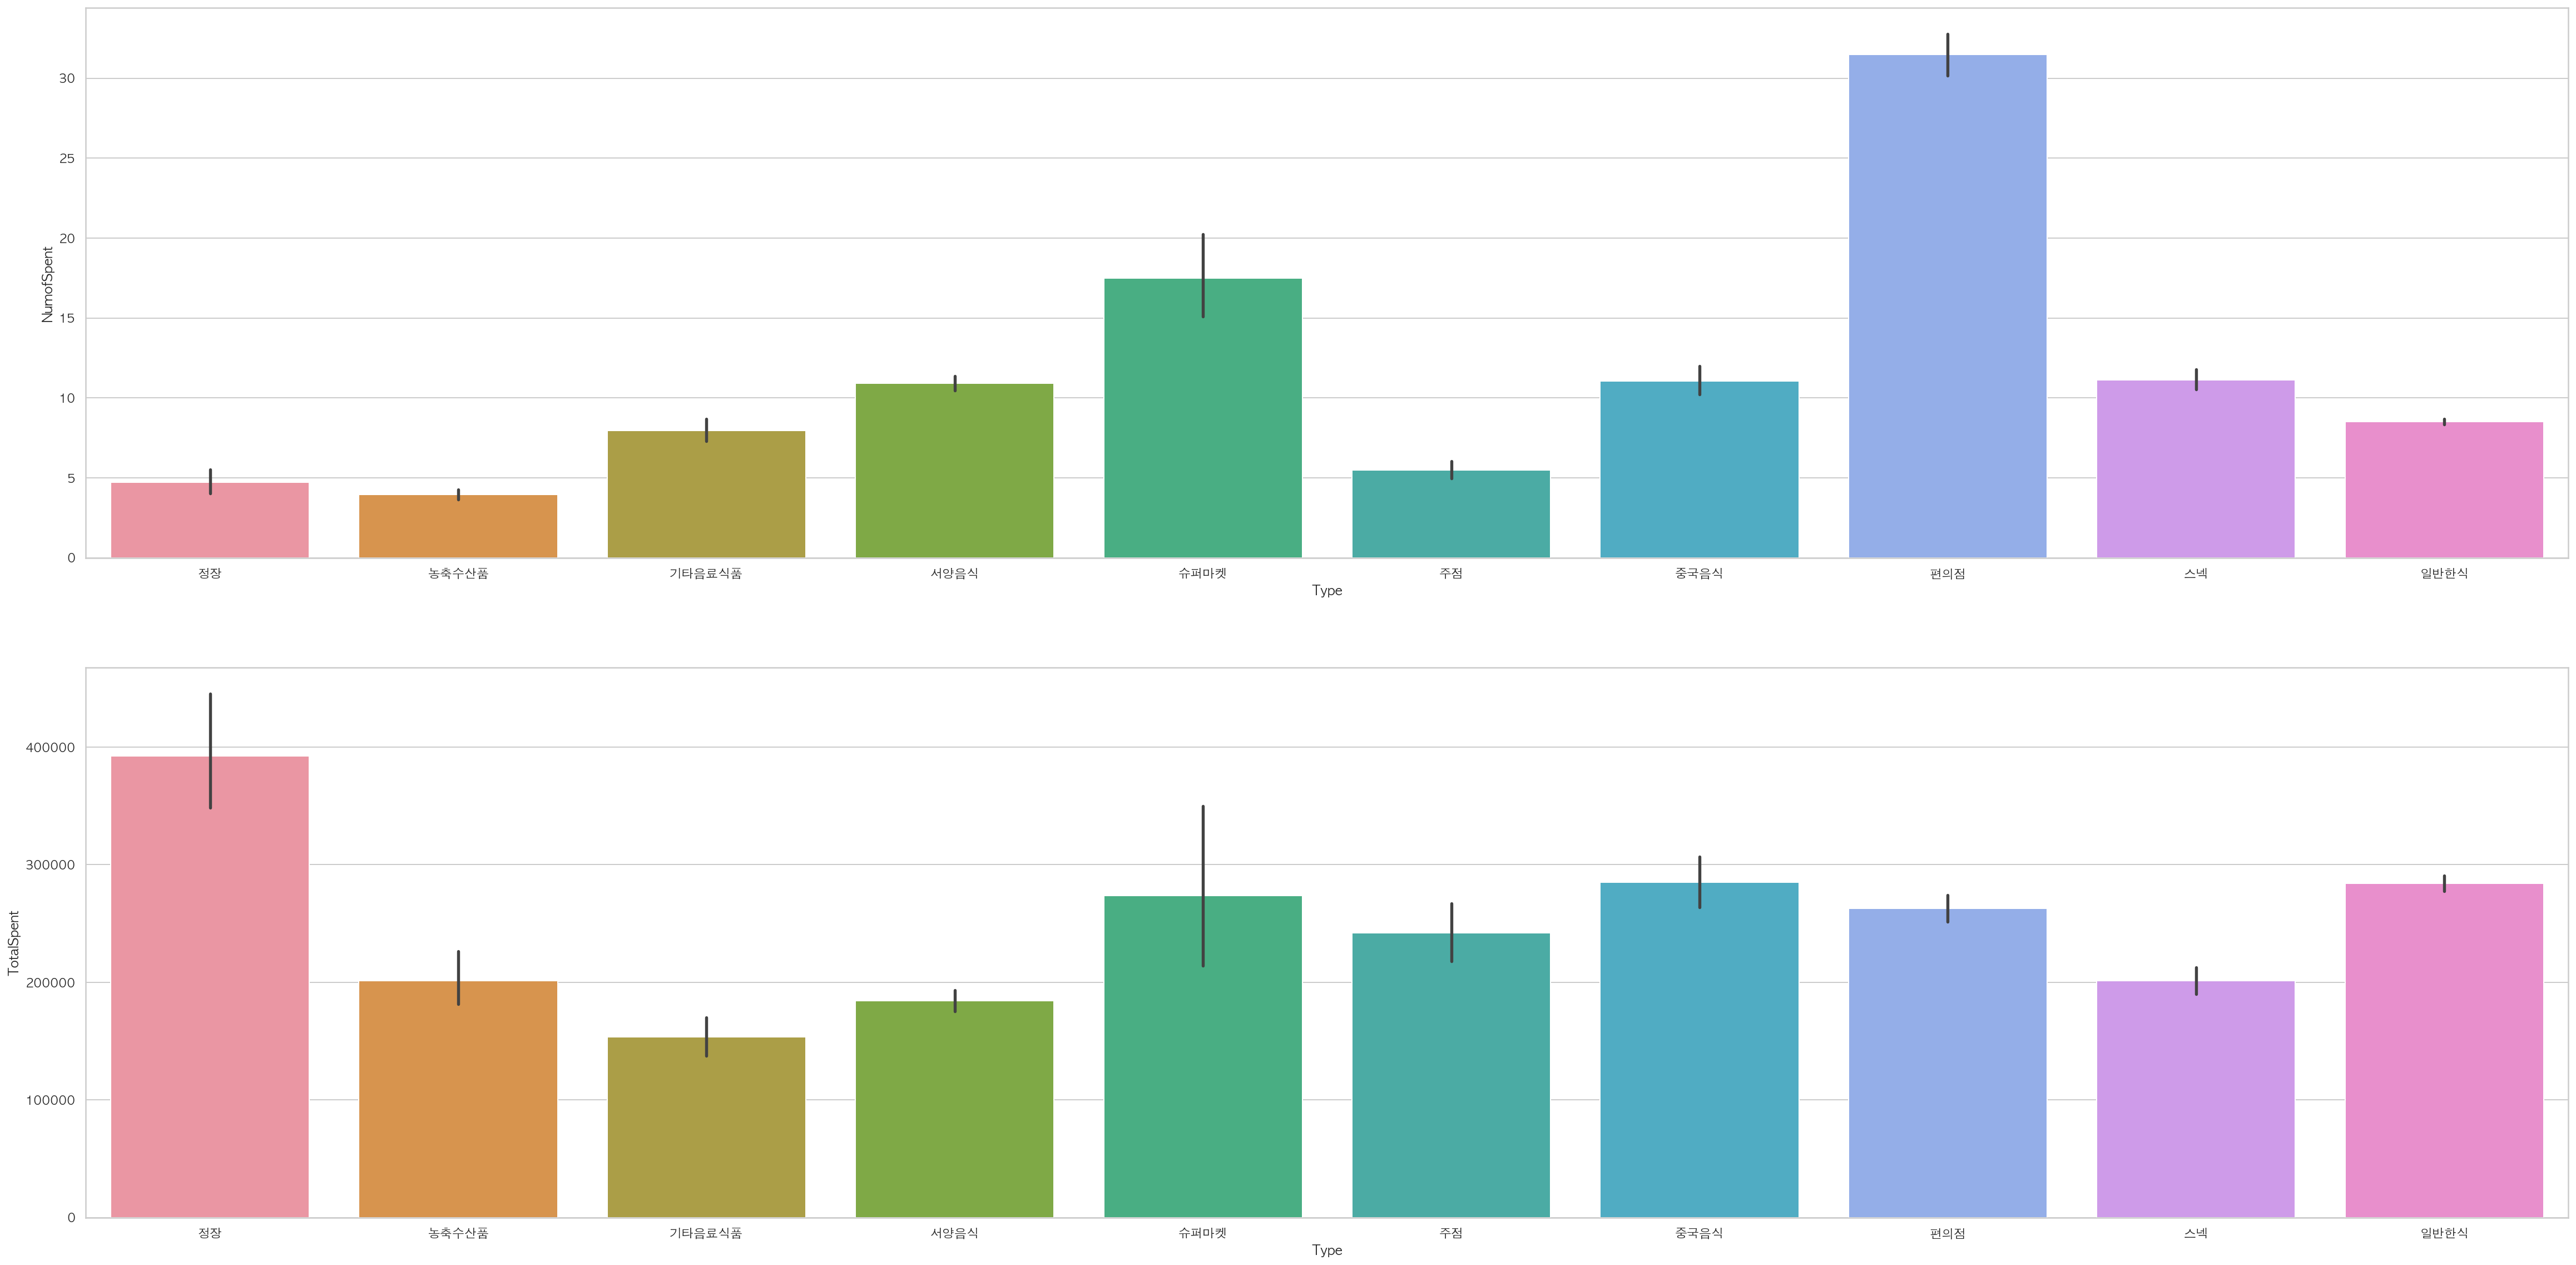

In [190]:
# top 8 읍,면,동 지역의 top 10 업종별 소비횟수, 총 매출액
sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
fig, axes = plt.subplots(2,1, figsize=(40,20))
sns.set_palette('Greens', 3)

sns.barplot(ax=axes[0], x='Type', y='NumofSpent', data=top_type_df)
sns.barplot(ax=axes[1], x='Type', y='TotalSpent', data=top_type_df)
plt.show()

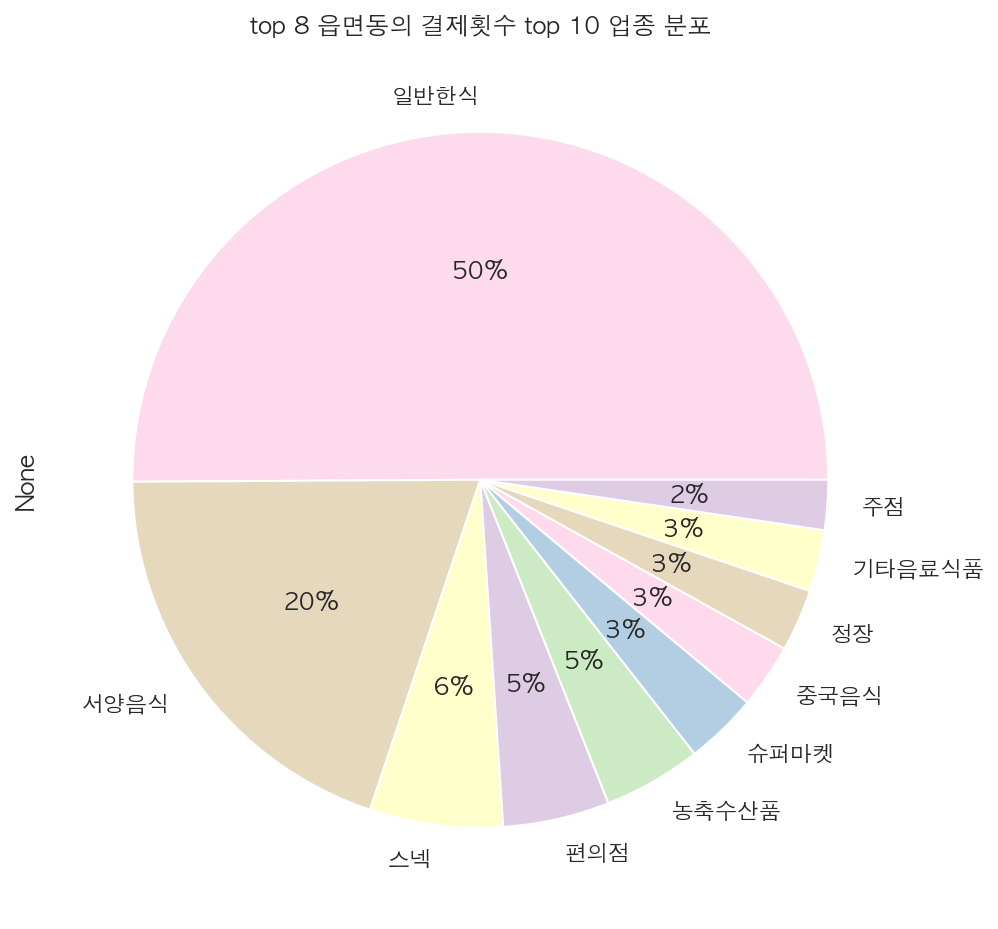

In [191]:
# 업종 분포
fig, axes = plt.subplots(1,1, figsize=(8,8))
sns.set_palette('Pastel1_r')

top_type_df.Type.str.split('|', expand=True).stack().value_counts().plot(kind='pie', title='top 8 읍면동의 결제횟수 top 10 업종 분포', autopct='%1.0f%%')
plt.show()

#### 지역별 비교
- '성산읍', '남원읍', '애월읍', '연동', '한림읍', '안덕면', '이도이동', '조천읍' 기준

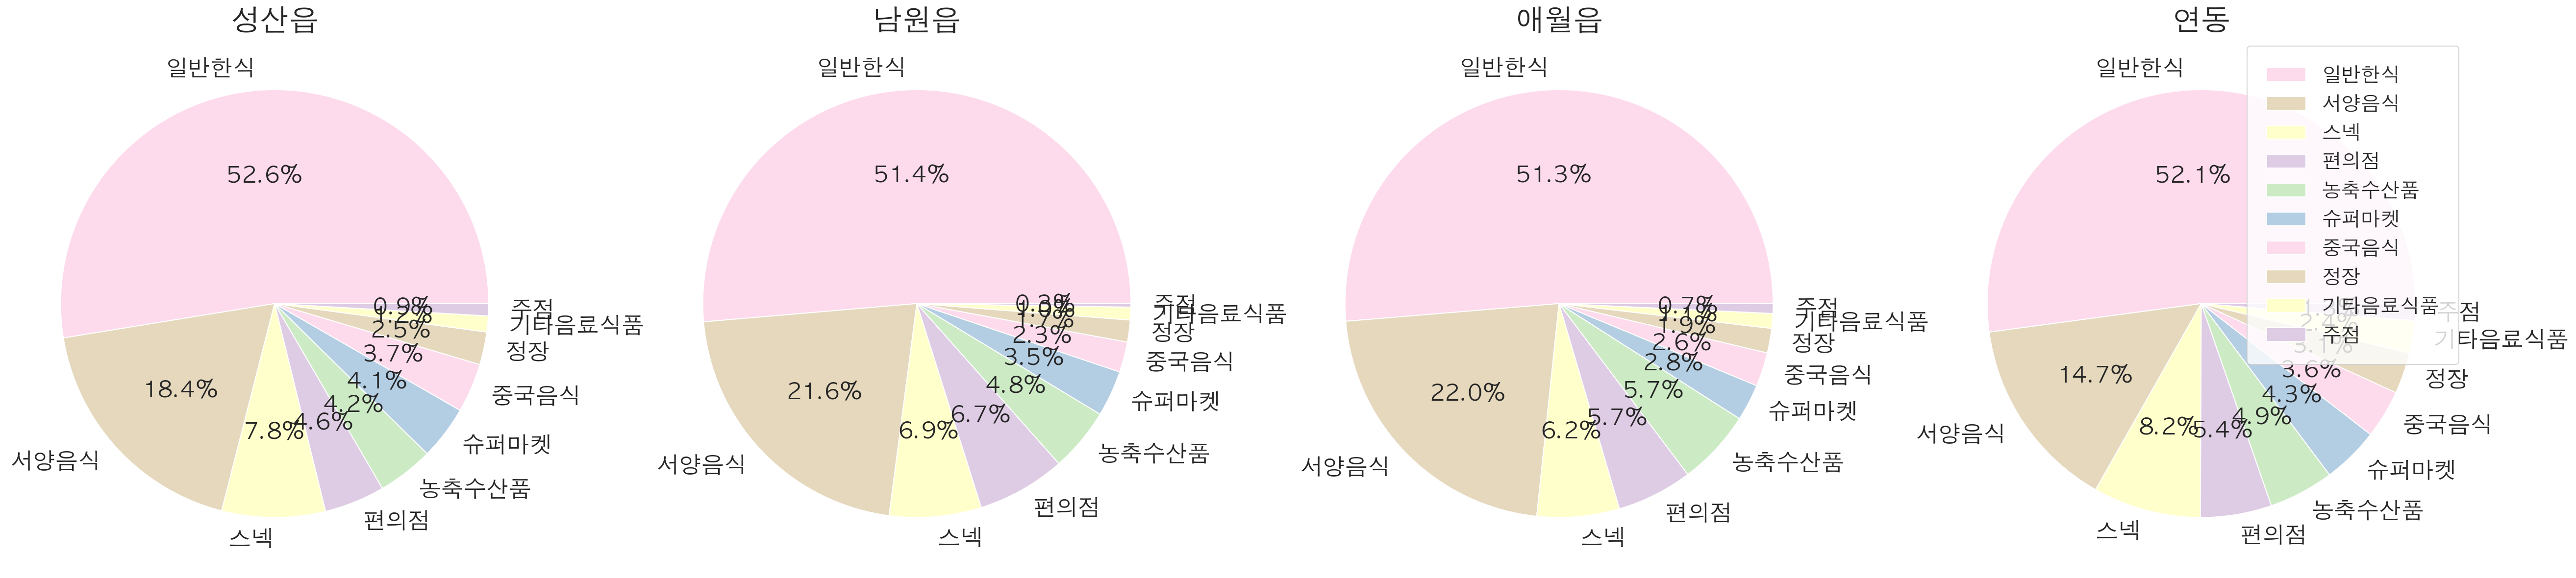

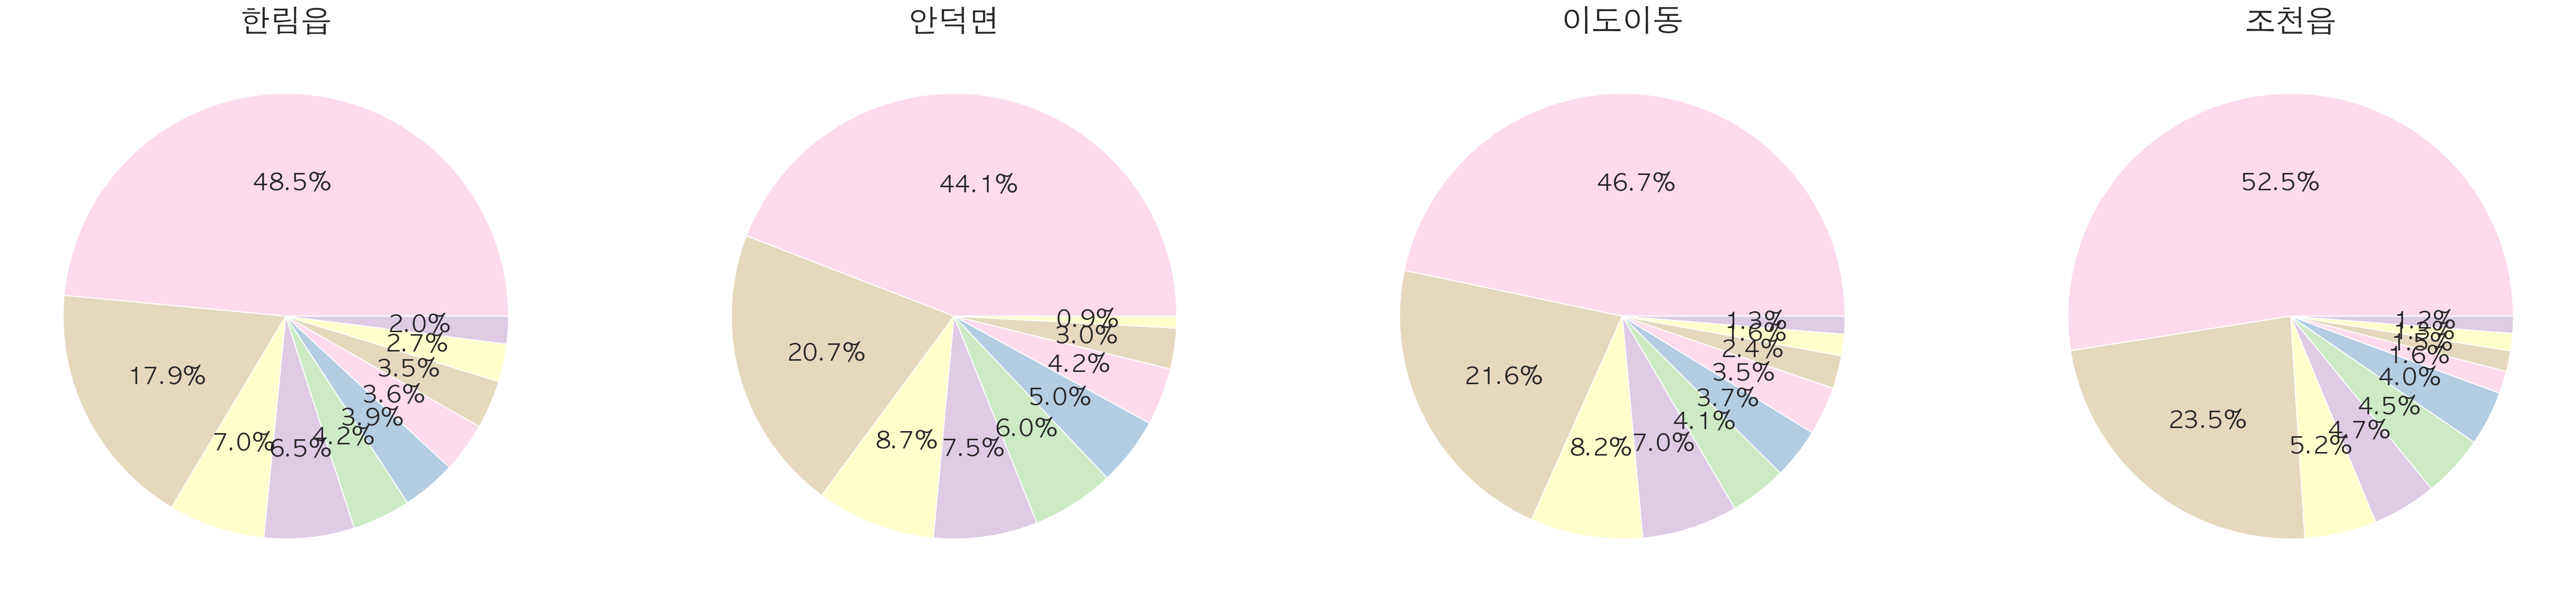

In [192]:
# 읍면동별 업종 소비 비중 비교
fig,ax = plt.subplots(1,4,figsize=(45,38))
# sns.set_palette('Pastel1', 3)
lbs = type_count.index.unique().tolist()
top_dong = ['성산읍', '남원읍', '애월읍', '연동', '한림읍', '안덕면', '이도이동', '조천읍']
max_range = 4

for i in range(max_range):
    ax[i].pie(top_type_df[top_type_df['Dong'] == top_dong[i]].Type.str.split('|', expand=True).stack().value_counts(), labels=lbs, autopct='%.1f%%', textprops={'fontsize':23})
    ax[i].set_title(top_dong[i], size=30)

plt.legend(lbs,loc=1,borderpad=1, prop={'size':20})
plt.show()

fig,ax = plt.subplots(1,4,figsize=(45,38))
sns.set_palette('Pastel1')

for i in range(max_range):
    ax[i].pie(top_type_df[top_type_df['Dong'] == top_dong[i+4]].Type.str.split('|', expand=True).stack().value_counts(), autopct='%.1f%%', textprops={'fontsize':23})
    ax[i].set_title(top_dong[i+4], size=30)
    
plt.show()

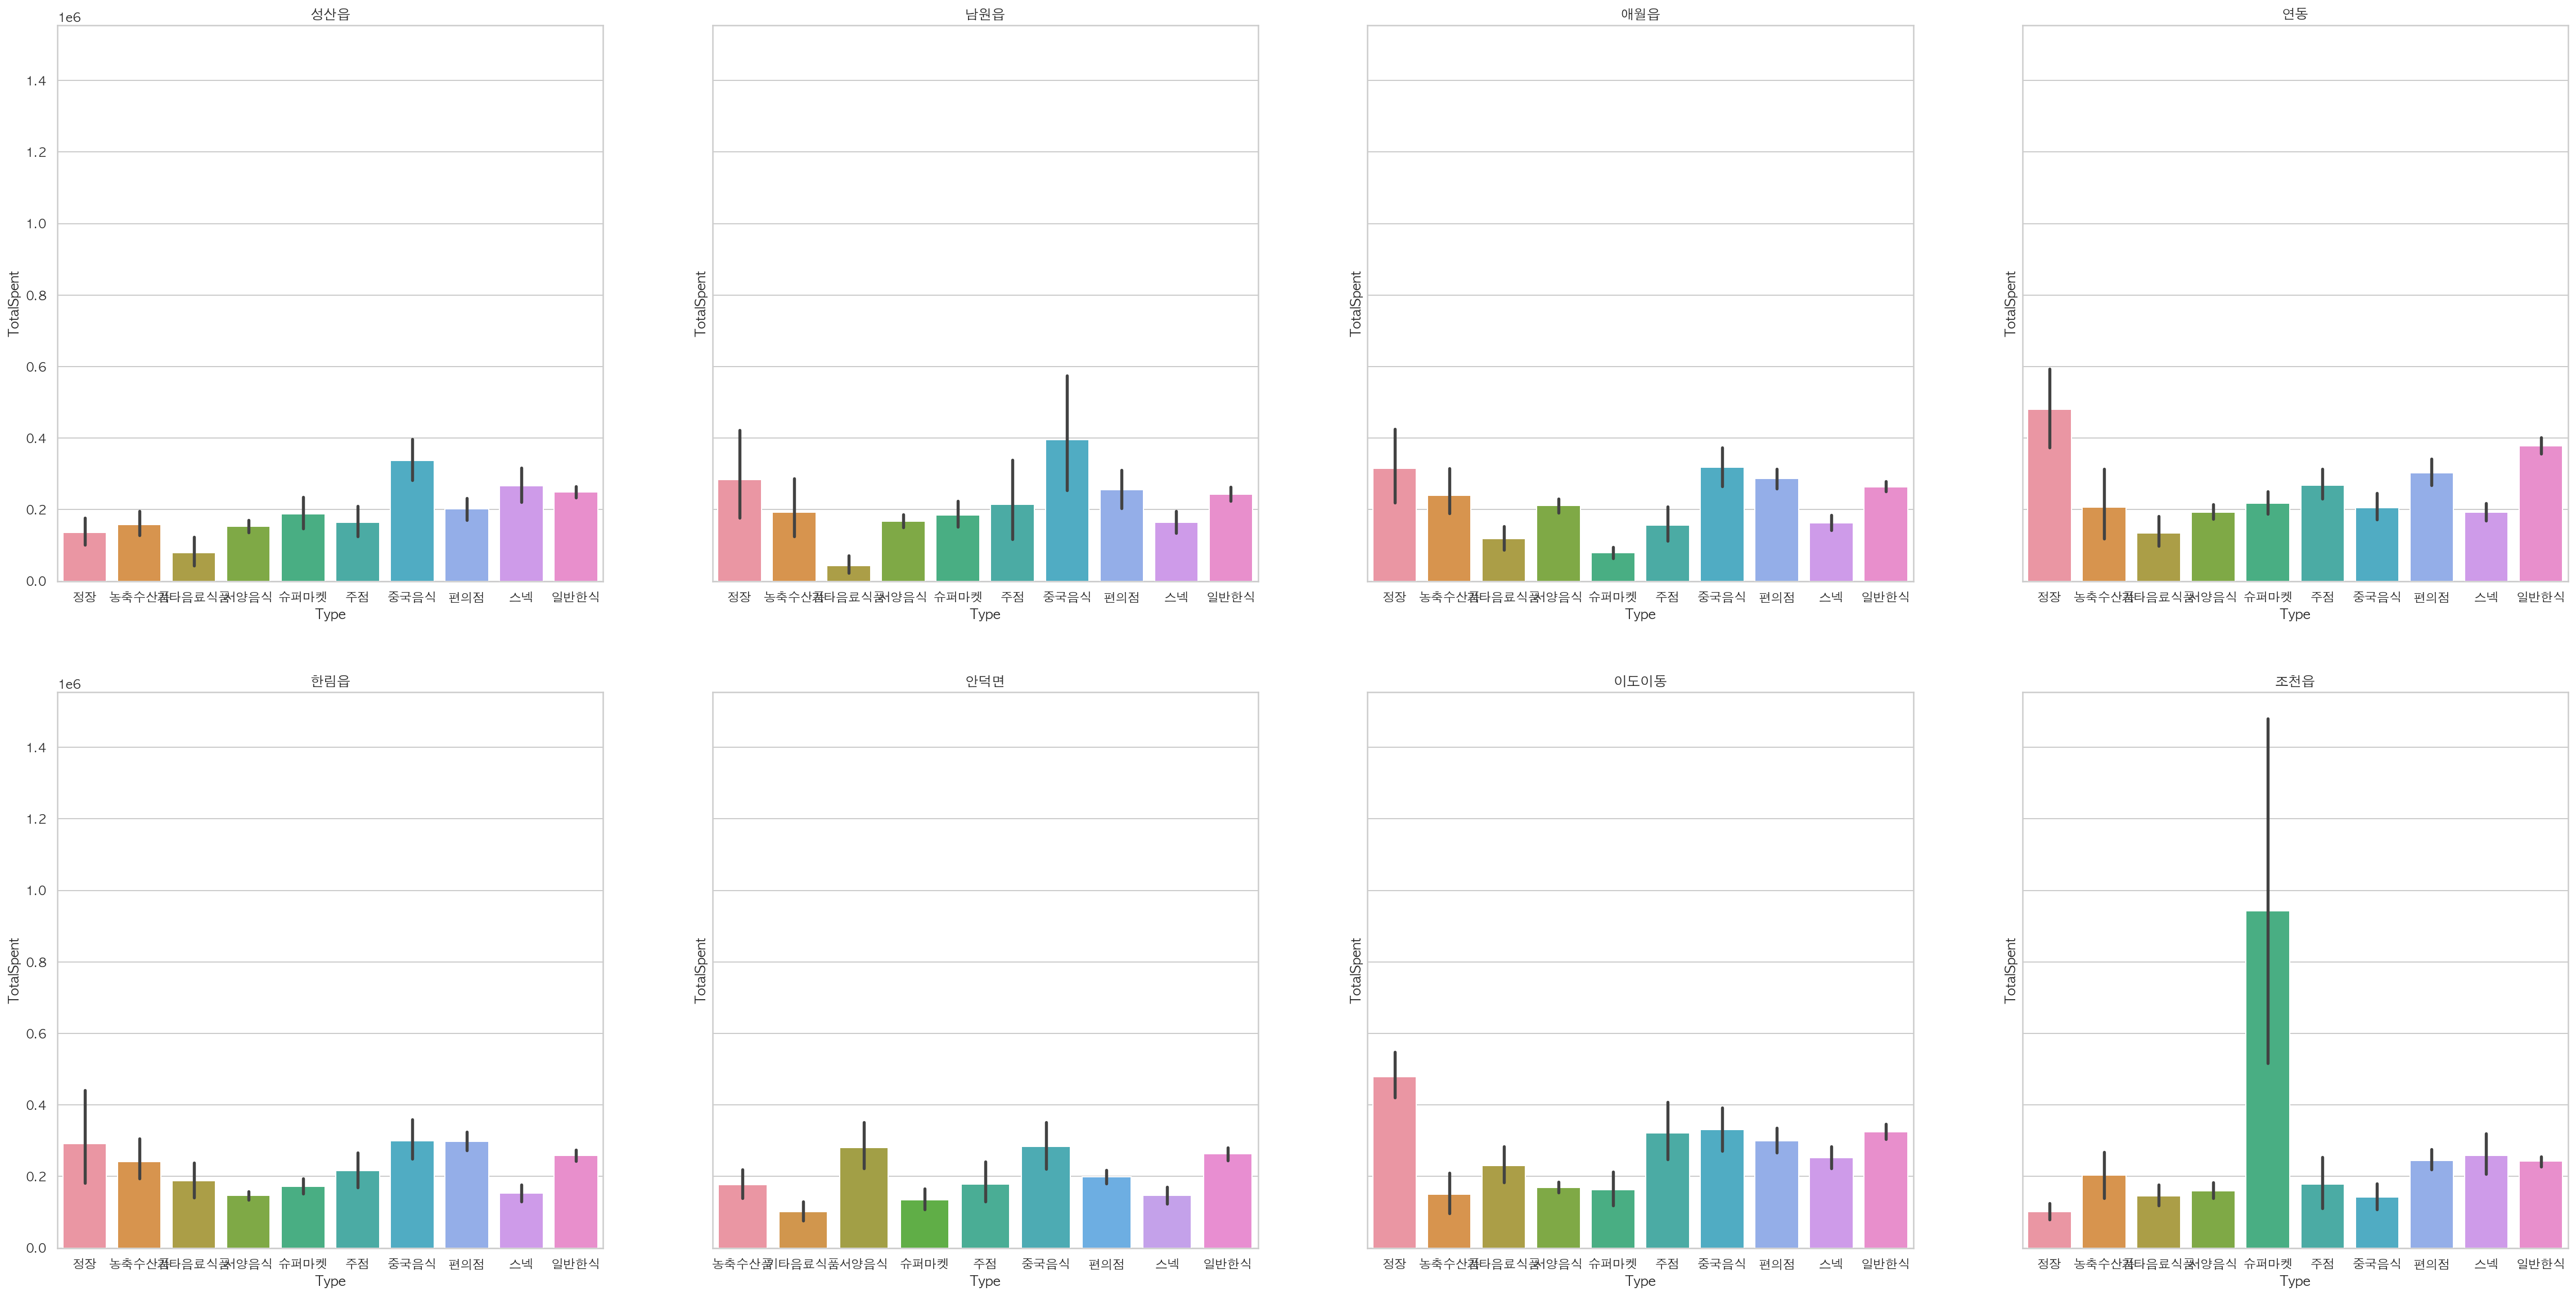

In [193]:
# top 8 읍면동 업종별 총 매출액 비교
sns.set(rc={'axes.unicode_minus':False}, font='AppleGothic', style='whitegrid')
fig, axes = plt.subplots(2,4, figsize=(40,20), sharey=True)


for i in range(4):
    sns.set_palette('Greens')
    sns.barplot(ax=axes[0][i], x='Type', y='TotalSpent', data=top_type_df[top_type_df['Dong'] == top_dong[i]]).set_title(top_dong[i])
    sns.barplot(ax=axes[1][i], x='Type', y='TotalSpent', data=top_type_df[top_type_df['Dong'] == top_dong[i+4]]).set_title(top_dong[i+4])
    
plt.show()

In [228]:
type_pivot = pd.pivot_table(columns= 'Dong', index='Type', values='TotalSpent', data =top_type_df, aggfunc='sum')
type_pivot

Dong            남원읍          성산읍          안덕면          애월읍           연동  \
Type                                                                      
기타음료식품     219000.0    2283400.0    9908170.0    8690315.0   17518550.0   
농축수산품    24102900.0   38954900.0   31174000.0   54139300.0   10987100.0   
서양음식     67898160.0   88969000.0  135874072.0  183034591.0  117874010.0   
슈퍼마켓     12051310.0   24070590.0   15633540.0    8681410.0   33096606.0   
스넥       21400200.0   35548700.0   20581814.0   40090098.0   65664830.0   
일반한식    234310216.0  412752855.0  271141420.0  533904431.0  822145278.0   
정장        5115000.0    5184500.0          NaN   13850460.0  107534260.0   
주점        6681100.0   12839514.0    3587600.0    4549100.0   54976800.0   
중국음식     16979012.0   48626484.0   19564500.0   32097000.0   36753000.0   
편의점      23015610.0   23573270.0   40296520.0   64198230.0   30879940.0   

Dong           이도이동          조천읍          한림읍  
Type                                           
기타음료식품   28284920.0   20328870.0   23585730.0  
농축수산품     7840350.0    9981000.0   54634400.0  
서양음식    122167250.0  113524680.0   90964300.0  
슈퍼마켓      7000410.0  112216917.0   20793350.0  
스넥       68626450.0   40519200.0   22455424.0  
일반한식    506355092.0  382373900.0  432979037.0  
정장      111293585.0    3873500.0   39722950.0  
주점       37569200.0    6584000.0   14937600.0  
중국음식     26545500.0    6401050.0   28493100.0  
편의점      41391170.0   33349990.0   72329340.0

In [230]:
top_type_gb = top_type_df.groupby(by='Type').sum()
top_type_gb = top_type_gb.iloc[:,:1]

fig = px.bar(type_pivot, barmode='stack',orientation='h',width=700)
fig.show()

서양음식 한식 정장 편의점 

In [220]:
# folium 지도 표시
def show_folium(target_type):
    
    # 제주시 행정구역 .shp 파일 geopandas로 불러오기
    emd = gpd.read_file("../datas/EMD_202101/TL_SCCO_EMD.shp", encoding='euc-kr')
    jeju_emd = emd.loc[(emd['EMD_CD'].str.startswith('5011')|emd['EMD_CD'].str.startswith('5013'))]
    jeju_emd['geometry'] = jeju_emd['geometry'].to_crs('EPSG:4326')


    # top 8 읍면동 기준으로 행정구역 정리
    indexlist = emd.index.tolist()
    targets = []
    top_dong = ['성산읍', '남원읍', '애월읍', '연동', '한림읍', '안덕면', '이도이동', '조천읍']

    for i in range(len(top_dong)):
        if top_dong[i] in jeju_emd['EMD_KOR_NM'].tolist():
            target_index = jeju_emd[jeju_emd['EMD_KOR_NM'] == top_dong[i]].index.tolist()
            targets.append(target_index[0])

    emd = emd.loc[targets]

    # top 8 읍면동 기준 '서양음식' TotalSpent
    target = top_type_df[top_type_df['Type'] == target_type]
    target.reset_index(drop=True, inplace=True)

    df_target = pd.DataFrame(target.groupby(['Dong'])['TotalSpent'].sum())

    f = folium.Figure(width=800, height=400)
    m = folium.Map(location = [33.363, 126.533], zoom_start= 10)
    m.add_to(f)

    folium.Choropleth(
                geo_data = emd, 
                data = df_target['TotalSpent'],
                key_on = 'feature.properties.EMD_KOR_NM',
                columns = (df_target.index, df_target['TotalSpent']),
                fill_color = 'YlOrRd',
                fill_opacity=0.5,
                line_opacity=0.5,
                overlays = True,
                highlight=True
             ).add_to(m)   
    return m

In [221]:
target_types = ['서양음식', '일반한식', '정장', '편의점']
# '서양음식' 지역별 매출 비교
show_folium(target_types[0])

In [222]:
# '일반한식' 지역별 매출 비교
show_folium(target_types[1])

In [223]:
# '정장' 지역별 매출 비교
show_folium(target_types[2])

In [224]:
# '편의점' 지역별 매출 비교
show_folium(target_types[3])